## keras_merge_3_app
整体说明：
- 1、使用keras的Xception、ResNet50、InceptonResNetV2预训练模型分别提取特征向量
- 2、整合3个模型的特征向量
- 3、构建一个简单模型，进行训练、预测



In [1]:
'''
数据目录结构：
data/
    train/    #原始数据，train.zip解压后生成
        dog.0.jpg
        cat.0.jpg
        ...
    train2/   #按标签分目录后的数据（连接文件）
        dog/
            dog.0.jpg
            dog.1.jpg
            ...
        cat/
            cat.0.jpg
            cat.1.jpg
            ...
    train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9961张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''
import cv2
import time
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *
from sklearn.utils import shuffle


train_data_dir = 'data/train2'
test_data_dir='data/test'


epochs=200
VER=1
#模型权重文件
model_h5file_base="Merge-tuning-v{}.h5".format(VER)
model_h5file_base2="Merge-tuning-2-v{}.h5".format(VER)

#预测结果文件
pred_file_base="pred-Merge-tuning-v{}.csv".format(VER)
pred_file_base2="pred-Merge-tuning-2-v{}.csv".format(VER)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#保存特征向量
def write_feature_data(MODEL, image_shape, weights_file, preprocess_input = None):
    input_tensor = Input((image_shape[0], image_shape[1], 3))
    x = input_tensor
    if preprocess_input:
        x = Lambda(preprocess_input)(x)
    
    base_model = MODEL(input_tensor=x, weights=weights_file, include_top=False) 
    
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(train_data_dir, image_shape, shuffle=False, 
                                              batch_size=90)
    test_generator = gen.flow_from_directory(test_data_dir, image_shape, shuffle=False, 
                                             batch_size=125, class_mode=None)
    
    train_feature = model.predict_generator(train_generator, train_generator.samples//90, verbose=1)
    test_feature = model.predict_generator(test_generator, test_generator.samples//125, verbose=1)
    
    with h5py.File("feature_%s.h5"%base_model.name) as h:
        h.create_dataset("train", data=train_feature)
        h.create_dataset("test", data=test_feature)
        h.create_dataset("label", data=train_generator.classes)

        
#用三个模型在imagenet上的预训练权重文件提取特征向量
write_feature_data(ResNet50, (224, 224), 'imagenet',  preprocess_input = resnet50.preprocess_input)
print("get ResNet50 freature over!")
write_feature_data(Xception, (299, 299), 'imagenet',  preprocess_input = xception.preprocess_input)
print("get Xception freature over!")
write_feature_data(InceptionResNetV2, (299, 299), 'imagenet',  preprocess_input = inception_resnet_v2.preprocess_input)
print("get InceptionResNetV2 freature over!")

Found 24930 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
100/100 [==============================] - 124s 1s/step
get ResNet50 freature over!
Found 24930 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
100/100 [==============================] - 301s 3s/step
get Xception freature over!
Found 24930 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
100/100 [==============================] - 354s 4s/step
get InceptionResNetV2 freature over!


In [2]:

#从文件中读取特征向量和标签

np.random.seed(2018)

X_train = []
X_test = []

for filename in ["feature_resnet50.h5", "feature_xception.h5", "feature_inception_resnet_v2.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)


In [3]:
#构造模型

input_tensor = Input(X_train.shape[1:])

x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [36]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如连续3个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/200
19944/19944 [==============================] - 5s 251us/step - loss: 0.0693 - acc: 0.9792 - val_loss: 0.0214 - val_acc: 0.9940

Epoch 00001: val_loss improved from inf to 0.02142, saving model to Merge-tuning-v1.h5
Epoch 2/200
19944/19944 [==============================] - 1s 46us/step - loss: 0.0202 - acc: 0.9954 - val_loss: 0.0214 - val_acc: 0.9966

Epoch 00002: val_loss improved from 0.02142 to 0.02139, saving model to Merge-tuning-v1.h5
Epoch 3/200
19944/19944 [==============================] - 1s 46us/step - loss: 0.0171 - acc: 0.9964 - val_loss: 0.0180 - val_acc: 0.9964

Epoch 00003: val_loss improved from 0.02139 to 0.01804, saving model to Merge-tuning-v1.h5
Epoch 4/200
19944/19944 [==============================] - 1s 46us/step - loss: 0.0152 - acc: 0.9965 - val_loss: 0.0174 - val_acc: 0.9956

Epoch 00004: val_loss improved from 0.01804 to 0.01737, saving model to Merge-tuning-v1.h5
Epoch 5/200
19944/19944 [=========

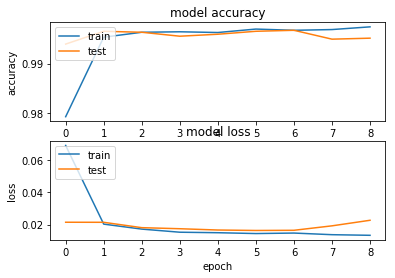

In [37]:
#可视化学习曲线
show_learning_curve(history)

In [4]:
#预测结果   
predict_on_model2(X_test,test_data_dir, 125, model, model_h5file_base, pred_file_base)

12500/12500 [==============================] - 1s 54us/step
Found 12500 images belonging to 1 classes.


/home/ubuntu/dogs-and-cats/helper.py:169: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index-1, 'label', y_test[i])


## 换个优化算法 

In [5]:
#构造模型

input_tensor = Input(X_train.shape[1:])

x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(x)
model2 = Model(input_tensor, x)

        adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #训练快,把lr设置小一点
model2.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [43]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base2, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如连续3个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model2.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/200
19944/19944 [==============================] - 5s 254us/step - loss: 0.9020 - acc: 0.4125 - val_loss: 0.7027 - val_acc: 0.5323

Epoch 00001: val_loss improved from inf to 0.70269, saving model to Merge-tuning-2-v1.h5
Epoch 2/200
19944/19944 [==============================] - 1s 46us/step - loss: 0.6604 - acc: 0.6241 - val_loss: 0.5077 - val_acc: 0.8389

Epoch 00002: val_loss improved from 0.70269 to 0.50766, saving model to Merge-tuning-2-v1.h5
Epoch 3/200
19944/19944 [==============================] - 1s 47us/step - loss: 0.4931 - acc: 0.7808 - val_loss: 0.3789 - val_acc: 0.9394

Epoch 00003: val_loss improved from 0.50766 to 0.37887, saving model to Merge-tuning-2-v1.h5
Epoch 4/200
19944/19944 [==============================] - 1s 47us/step - loss: 0.3857 - acc: 0.8717 - val_loss: 0.2920 - val_acc: 0.9705

Epoch 00004: val_loss improved from 0.37887 to 0.29201, saving model to Merge-tuning-2-v1.h5
Epoch 5/200
19944/19944 [=

19944/19944 [==============================] - 1s 46us/step - loss: 0.0311 - acc: 0.9939 - val_loss: 0.0259 - val_acc: 0.9944

Epoch 00036: val_loss improved from 0.02648 to 0.02586, saving model to Merge-tuning-2-v1.h5
Epoch 37/200
19944/19944 [==============================] - 1s 47us/step - loss: 0.0299 - acc: 0.9944 - val_loss: 0.0253 - val_acc: 0.9944

Epoch 00037: val_loss improved from 0.02586 to 0.02529, saving model to Merge-tuning-2-v1.h5
Epoch 38/200
19944/19944 [==============================] - 1s 46us/step - loss: 0.0284 - acc: 0.9940 - val_loss: 0.0248 - val_acc: 0.9946

Epoch 00038: val_loss improved from 0.02529 to 0.02476, saving model to Merge-tuning-2-v1.h5
Epoch 39/200
19944/19944 [==============================] - 1s 46us/step - loss: 0.0292 - acc: 0.9941 - val_loss: 0.0243 - val_acc: 0.9948

Epoch 00039: val_loss improved from 0.02476 to 0.02429, saving model to Merge-tuning-2-v1.h5
Epoch 40/200
19944/19944 [==============================] - 1s 47us/step - loss: 

Epoch 107/200
19944/19944 [==============================] - 1s 46us/step - loss: 0.0163 - acc: 0.9965 - val_loss: 0.0173 - val_acc: 0.9962

Epoch 00107: val_loss did not improve from 0.01725
Epoch 108/200
19944/19944 [==============================] - 1s 53us/step - loss: 0.0153 - acc: 0.9969 - val_loss: 0.0172 - val_acc: 0.9962

Epoch 00108: val_loss improved from 0.01725 to 0.01723, saving model to Merge-tuning-2-v1.h5
Epoch 109/200
19944/19944 [==============================] - 1s 54us/step - loss: 0.0152 - acc: 0.9967 - val_loss: 0.0172 - val_acc: 0.9962

Epoch 00109: val_loss improved from 0.01723 to 0.01721, saving model to Merge-tuning-2-v1.h5
Epoch 110/200
19944/19944 [==============================] - 1s 52us/step - loss: 0.0162 - acc: 0.9965 - val_loss: 0.0172 - val_acc: 0.9962

Epoch 00110: val_loss improved from 0.01721 to 0.01720, saving model to Merge-tuning-2-v1.h5
Epoch 111/200
19944/19944 [==============================] - 1s 47us/step - loss: 0.0160 - acc: 0.9966 - v

Epoch 144/200
19944/19944 [==============================] - 1s 46us/step - loss: 0.0146 - acc: 0.9968 - val_loss: 0.0169 - val_acc: 0.9962

Epoch 00144: val_loss did not improve from 0.01689
Epoch 145/200
19944/19944 [==============================] - 1s 47us/step - loss: 0.0138 - acc: 0.9972 - val_loss: 0.0169 - val_acc: 0.9962

Epoch 00145: val_loss improved from 0.01689 to 0.01686, saving model to Merge-tuning-2-v1.h5
Epoch 146/200
19944/19944 [==============================] - 1s 47us/step - loss: 0.0149 - acc: 0.9966 - val_loss: 0.0169 - val_acc: 0.9962

Epoch 00146: val_loss did not improve from 0.01686
Epoch 147/200
19944/19944 [==============================] - 1s 47us/step - loss: 0.0148 - acc: 0.9966 - val_loss: 0.0168 - val_acc: 0.9962

Epoch 00147: val_loss improved from 0.01686 to 0.01685, saving model to Merge-tuning-2-v1.h5
Epoch 148/200
19944/19944 [==============================] - 1s 47us/step - loss: 0.0142 - acc: 0.9969 - val_loss: 0.0168 - val_acc: 0.9962

Epoch 0

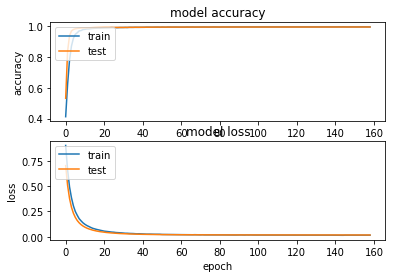

In [44]:
#可视化学习曲线
show_learning_curve(history)

In [6]:
#预测结果   
#predict_on_model(X_test, model, model_h5file_base2, pred_file_base2)
predict_on_model2(X_test,test_data_dir, 125, model, model_h5file_base2, pred_file_base2)

12500/12500 [==============================] - 1s 43us/step
Found 12500 images belonging to 1 classes.


/home/ubuntu/dogs-and-cats/helper.py:169: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index-1, 'label', y_test[i])
